<font size="8">Trace Analysis Examples</font>
<br>
<font size="5">Tasks Latencies</font>
<br>
<hr>

# Import Required Modules

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support for workload generation
from wlgen import RTA, Ramp

# Support for trace analysis
from trace import Trace

# Support for plotting
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

02:46:33  DEBUG   : loading JSON...
02:46:33  DEBUG   : Loaded JSON configuration:
02:46:33  DEBUG   :    {u'nrg_model': {u'big': {u'cluster': {u'nrg_max': 112}, u'cpu': {u'cap_max': 1024, u'nrg_max': 670}}, u'little': {u'cluster': {u'nrg_max': 112}, u'cpu': {u'cap_max': 1024, u'nrg_max': 670}}}, u'board': {u'big_core': u'A53_1', u'cores': [u'A53_0', u'A53_0', u'A53_0', u'A53_0', u'A53_1', u'A53_1', u'A53_1', u'A53_1'], u'modules': [u'bl', u'cpufreq', u'cpuidle']}}
02:46:33  DEBUG   : loading JSON...
02:46:33  DEBUG   : Loaded JSON configuration:
02:46:33  DEBUG   :    {u'board': {u'big_core': u'A57', u'cores': [u'A53', u'A53', u'A53', u'A53', u'A57', u'A57'], u'modules': [u'bl', u'cpufreq']}}
02:46:33  DEBUG   : loading JSON...
02:46:33  DEBUG   : Loaded JSON configuration:
02:46:33  DEBUG   :    {u'nrg_model': {u'big': {u'cluster': {u'nrg_max': 96}, u'cpu': {u'cap_max': 1024, u'nrg_max': 1715}}, u'little': {u'cluster': {u'nrg_max': 52}, u'cpu': {u'cap_max': 763, u'nrg_max': 925}}}, u

# Target Configuration

In [6]:
# Setup target configuration
androidsdk_path=os.path.join(os.getcwd(), "../../../android-sdk")
my_conf = {

    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : androidsdk_path,
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
#             'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Folder where all the results will be collected
    "results_dir" : "Task_Latencies",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],

}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf)
target = te.target

11:00:32  INFO    : Using base path: /home/steven/lisa/lisa-github
11:00:32  INFO    : Loading custom (inline) target configuration
11:00:32  DEBUG   : Target configuration {'platform': 'android', 'emeter': {'instrument': 'acme', 'channel_map': {'Device1': 1, 'Device0': 0}, 'conf': {'iio-capture': '/usr/bin/iio-capture'}}, 'ftrace': {'buffsize': 102400, 'events': ['sched_switch', 'sched_wakeup', 'sched_load_avg_cpu', 'sched_load_avg_task']}, 'board': 'hikey960', 'rtapp-calib': {'1': 302, '0': 302, '3': 304, '2': 304, '5': 137, '4': 136, '7': 136, '6': 136}, 'exclude_modules': ['hwmon'], 'device': '0123456789ABCDEF', 'ANDROID_HOME': '/home/steven/lisa/lisa-github/ipynb/kpti_test/../../../android-sdk', 'tools': ['trace-cmd', 'rt-app'], 'results_dir': 'Task_Latencies'}
11:00:32  WARNING : Wipe previous contents of the results folder:
11:00:32  WARNING :    /home/steven/lisa/lisa-github/results/Task_Latencies
11:00:32  INFO    : External tools using:
11:00:32  INFO    :    ANDROID_HOME: /h

11:00:41  DEBUG   : adb -s 0123456789ABCDEF shell mount
11:00:41  DEBUG   : adb -s 0123456789ABCDEF push '/home/steven/lisa/lisa-github/tools/arm64/rt-app' '/data/local/tmp/devlib-target/rt-app'
11:00:41  DEBUG   : adb -s 0123456789ABCDEF shell echo 'cp /data/local/tmp/devlib-target/rt-app /data/local/tmp/bin/rt-app' | su
11:00:41  DEBUG   : adb -s 0123456789ABCDEF shell echo 'rm -rf "/data/local/tmp/devlib-target/rt-app"' | su
11:00:41  DEBUG   : adb -s 0123456789ABCDEF shell echo 'chmod 0777 '\''/data/local/tmp/bin/rt-app'\''' | su
11:00:41  DEBUG   : adb -s 0123456789ABCDEF shell mount
11:00:42  DEBUG   : adb -s 0123456789ABCDEF push '/home/steven/lisa/lisa-github/tools/arm64/perf' '/data/local/tmp/devlib-target/perf'
11:00:42  DEBUG   : adb -s 0123456789ABCDEF shell echo 'cp /data/local/tmp/devlib-target/perf /data/local/tmp/bin/perf' | su
11:00:42  DEBUG   : adb -s 0123456789ABCDEF shell echo 'rm -rf "/data/local/tmp/devlib-target/perf"' | su
11:00:42  DEBUG   : adb -s 0123456789A

# Workload Execution

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get(),
                    'ramp1' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get(),
                    'ramp2' : Ramp(
                        start_pct =  20,
                        end_pct   =  60,
                        delta_pct =   5,
                        time_s    =   0.5).get(),
                    'ramp3' : Ramp(
                        start_pct =  20,
                        end_pct   =  60,
                        delta_pct =   5,
                        time_s    =   0.5).get(),
#                     'ramp4' : Ramp(
#                         start_pct =  20,
#                         end_pct   =  60,
#                         delta_pct =   5,
#                         time_s    =   0.5).get(),
#                     'ramp5' : Ramp(
#                         start_pct =  20,
#                         end_pct   =  60,
#                         delta_pct =   5,
#                         time_s    =   0.5).get(),
#                     'ramp6' : Ramp(
#                         start_pct =  20,
#                         end_pct   =  60,
#                         delta_pct =   5,
#                         time_s    =   0.5).get(),
#                     'ramp7' : Ramp(
#                         start_pct =  20,
#                         end_pct   =  60,
#                         delta_pct =   5,
#                         time_s    =   0.5).get(),
                   
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

11:00:46  INFO    : Setup new workload ramp
11:00:46  DEBUG   : Setup step [postrun] callback to [__postrun] function
11:00:46  DEBUG   : adb -s 0123456789ABCDEF shell mkdir -p /data/local/tmp/devlib-target
11:00:47  DEBUG   : Configuring a profile-based workload...
11:00:47  INFO    : Workload duration defined by longest task
11:00:47  INFO    : Default policy: SCHED_OTHER
11:00:47  INFO    : ------------------------
11:00:47  INFO    : task [ramp], sched: using default policy
11:00:47  INFO    :  | loops count: 1
11:00:47  INFO    : + phase_000001: duration 0.500000 [s] (5 loops)
11:00:47  INFO    : |  period   100000 [us], duty_cycle  60 %
11:00:47  INFO    : |  run_time  60000 [us], sleep_time  40000 [us]
11:00:47  INFO    : + phase_000002: duration 0.500000 [s] (5 loops)
11:00:47  INFO    : |  period   100000 [us], duty_cycle  55 %
11:00:47  INFO    : |  run_time  55000 [us], sleep_time  45000 [us]
11:00:47  INFO    : + phase_000003: duration 0.500000 [s] (5 loops)
11:00:47  INFO 

11:00:47  DEBUG   : adb -s 0123456789ABCDEF shell echo 'cat '\''/sys/kernel/debug/tracing/buffer_size_kb'\''' | su
11:00:47  DEBUG   : adb -s 0123456789ABCDEF shell echo '/data/local/tmp/bin/trace-cmd reset' | su
11:00:51  DEBUG   : adb -s 0123456789ABCDEF shell echo '/data/local/tmp/bin/trace-cmd start -e sched_switch -e sched_wakeup -e sched_load_avg_cpu -e sched_load_avg_task' | su
11:00:54  DEBUG   : adb -s 0123456789ABCDEF shell echo 'echo TRACE_MARKER_START > '\''/sys/kernel/debug/tracing/trace_marker'\''' | su
11:00:55  DEBUG   : Trace CPUFreq frequencies
11:00:55  DEBUG   : adb -s 0123456789ABCDEF shell echo '/data/local/tmp/bin/shutils cpufreq_trace_all_frequencies' | su
11:00:55  DEBUG   : Trace CPUIdle states
11:00:55  DEBUG   : adb -s 0123456789ABCDEF shell /data/local/tmp/bin/shutils cpuidle_wake_all_cpus
11:00:55  INFO    : Workload execution START:
11:00:55  INFO    :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/ramp_00.json 2>&1
11:00:55  DEBUG   : adb -s

# Parse Trace and Profiling Data

In [3]:
# Base folder where tests folder are located
res_dir = '/home/steven/lisa/lisa-github/results/kpti/base/latency-1'
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

02:47:13  INFO    : Content of the output folder /home/steven/lisa/lisa-github/results/kpti/base/latency-1


/home/steven/lisa/lisa-github/results/kpti/base/latency-1
├── ftrace.sh
├── function.stats
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── rt-app-ramp1-1.log
├── rt-app-ramp2-2.log
├── rt-app-ramp3-3.log
└── trace.dat

0 directories, 9 files


In [4]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

02:47:20  INFO    : LITTLE cluster max capacity: 462


In [7]:
trace_file = os.path.join(res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

02:47:42  DEBUG   : Loading [sched] events from trace in [/home/steven/lisa/lisa-github/results/kpti/base/latency-1/trace.dat]...
02:47:42  DEBUG   : Parsing events: ['sched_switch', 'sched_wakeup', 'sched_load_avg_cpu', 'sched_load_avg_task']
02:47:42  DEBUG   : Parsing FTrace format...
02:47:42  DEBUG   : Events found on trace:
02:47:42  DEBUG   :  - sched_switch
02:47:42  DEBUG   :  - sched_wakeup
02:47:42  DEBUG   : Collected events spans a 5.895 [s] time interval
02:47:42  DEBUG   : Set plots time range to (0.000000, 5.894723)[s]
02:47:42  DEBUG   : Registering [<trace.Trace object at 0x7f6ad5a28b10>] local data frames
02:47:42  DEBUG   :    functions_stats
02:47:42  DEBUG   :    trace_event
02:47:42  DEBUG   : Analysis: /home/steven/lisa/lisa-github/libs/utils/analysis
02:47:42  DEBUG   : Syspath: ['/home/steven/lisa/lisa-github/libs/utils/analysis', '', '/home/steven/lisa/lisa-github/libs/bart', '/home/steven/lisa/lisa-github/libs/trappy', '/home/steven/lisa/lisa-github/libs/dev

In [16]:
res_dir = '/home/steven/lisa/lisa-github/results/kpti/kpti/latency-1'
logging.info('Content of the output folder %s', res_dir)
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])
trace_file = os.path.join(res_dir, 'trace.dat')
trace_kpti = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

02:50:52  INFO    : Content of the output folder /home/steven/lisa/lisa-github/results/kpti/kpti/latency-1
02:50:52  INFO    : LITTLE cluster max capacity: 462
02:50:52  DEBUG   : Loading [sched] events from trace in [/home/steven/lisa/lisa-github/results/kpti/kpti/latency-1/trace.dat]...
02:50:52  DEBUG   : Parsing events: ['sched_switch', 'sched_wakeup', 'sched_load_avg_cpu', 'sched_load_avg_task']
02:50:52  DEBUG   : Parsing FTrace format...
02:50:53  DEBUG   : Events found on trace:
02:50:53  DEBUG   :  - sched_switch
02:50:53  DEBUG   :  - sched_wakeup
02:50:53  DEBUG   : Collected events spans a 5.833 [s] time interval
02:50:53  DEBUG   : Set plots time range to (0.000000, 5.832646)[s]
02:50:53  DEBUG   : Registering [<trace.Trace object at 0x7f6ad353f0d0>] local data frames
02:50:53  DEBUG   :    functions_stats
02:50:53  DEBUG   :    trace_event
02:50:53  DEBUG   : Analysis: /home/steven/lisa/lisa-github/libs/utils/analysis
02:50:53  DEBUG   : Syspath: ['/home/steven/lisa/lisa-

# Trace visualization

In [8]:
trappy.plotter.plot_trace(trace.ftrace)

# Latency DataFrames

In [9]:
# Report full set of task status informations available from the trace
trace.data_frame.latency_df('ramp').head()

02:47:54  INFO    : Parsing sched_switch states assuming kernel v4.9
02:47:54  INFO    : Parsing sched_switch states assuming kernel v4.9
02:47:54  INFO    : Parsing sched_switch states assuming kernel v4.9
02:47:54  INFO    : Parsing sched_switch states assuming kernel v4.9


,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
0.992100,NaN,6.0,A,T,0.992100,0.000072
0.992172,NaN,6.0,T,W,0.992172,0.000010
0.992182,6.0,NaN,W,A,0.992182,0.000003
0.992185,NaN,6.0,A,D,0.992185,0.000030
0.992215,NaN,6.0,D,W,0.992215,0.000095


In [10]:
trace.data_frame.latency_df('ramp')

02:48:03  INFO    : Parsing sched_switch states assuming kernel v4.9
02:48:03  INFO    : Parsing sched_switch states assuming kernel v4.9
02:48:03  INFO    : Parsing sched_switch states assuming kernel v4.9
02:48:03  INFO    : Parsing sched_switch states assuming kernel v4.9


,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
0.992100,NaN,6.0,A,T,0.992100,0.000072
0.992172,NaN,6.0,T,W,0.992172,0.000010
0.992182,6.0,NaN,W,A,0.992182,0.000003
0.992185,NaN,6.0,A,D,0.992185,0.000030
0.992215,NaN,6.0,D,W,0.992215,0.000095
0.992310,6.0,NaN,W,A,0.992310,0.000002
0.992312,NaN,6.0,A,D,0.992312,0.000008
0.992320,NaN,6.0,D,W,0.992320,0.000017
0.992337,6.0,NaN,W,A,0.992337,0.000003


In [11]:
df = trace.data_frame.trace_event('sched_switch')
df.head()

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
0.000064,trace-cmd,1,1,2148,swapper/1,0,120,trace-cmd,2148,120,64
0.000247,<idle>,0,2,0,ftrace.sh,2146,120,swapper/0,0,120,1
0.001990,ftrace.sh,0,5,2146,kworker/0:1,97,120,ftrace.sh,2146,120,256
0.002067,<idle>,2,8,0,rcu_sched,9,120,swapper/2,0,120,1
0.002166,rcu_sched,2,9,9,swapper/2,0,120,rcu_sched,9,120,256


In [12]:
# Report WAKEUP events and their duration
trace.data_frame.latency_wakeup_df('ramp').head()

02:48:05  INFO    : Parsing sched_switch states assuming kernel v4.9
02:48:06  INFO    : Parsing sched_switch states assuming kernel v4.9
02:48:06  INFO    : Parsing sched_switch states assuming kernel v4.9
02:48:06  INFO    : Parsing sched_switch states assuming kernel v4.9


,wakeup_latency
Time,
0.992182,0.000003
0.992310,0.000002
0.992337,0.000003
0.992423,0.000004
1.602279,0.000008


In [13]:
# Report PREEMPTION events and their duration
trace.data_frame.latency_preemption_df('ramp').head()

02:48:07  INFO    : Parsing sched_switch states assuming kernel v4.9
02:48:07  INFO    : Parsing sched_switch states assuming kernel v4.9
02:48:07  INFO    : Parsing sched_switch states assuming kernel v4.9
02:48:07  INFO    : Parsing sched_switch states assuming kernel v4.9


,preempt_latency
Time,


## Latency Plots

# Latency Plot base kernel

02:48:09  INFO    : Found:    44 WAKEUP latencies
02:48:09  INFO    : Found:     0 PREEMPT latencies
02:48:09  INFO    : Total:    44 latency events
02:48:09  INFO    : 100.0 % samples below 1 [ms] threshold
02:48:09  WARNING : Event [sched_overutilized] not found, plot DISABLED!


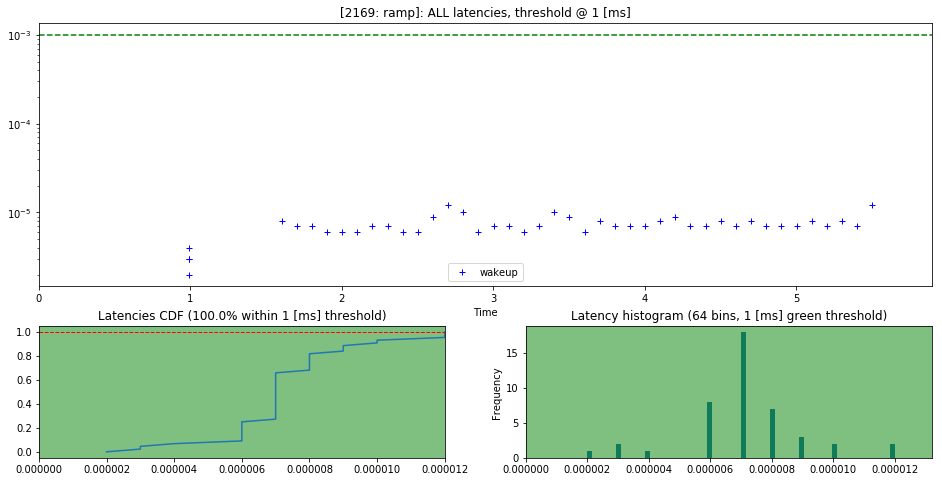

In [14]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('ramp')

# Latency Plot kpti enabled kernel

02:51:40  INFO    : Parsing sched_switch states assuming kernel v4.9
02:51:40  INFO    : Parsing sched_switch states assuming kernel v4.9
02:51:40  INFO    : Parsing sched_switch states assuming kernel v4.9
02:51:40  INFO    : Parsing sched_switch states assuming kernel v4.9
02:51:40  INFO    : Found:    28 WAKEUP latencies
02:51:40  INFO    : Found:     0 PREEMPT latencies
02:51:40  INFO    : Total:    28 latency events
02:51:40  INFO    : 100.0 % samples below 1 [ms] threshold
02:51:40  WARNING : Event [sched_overutilized] not found, plot DISABLED!


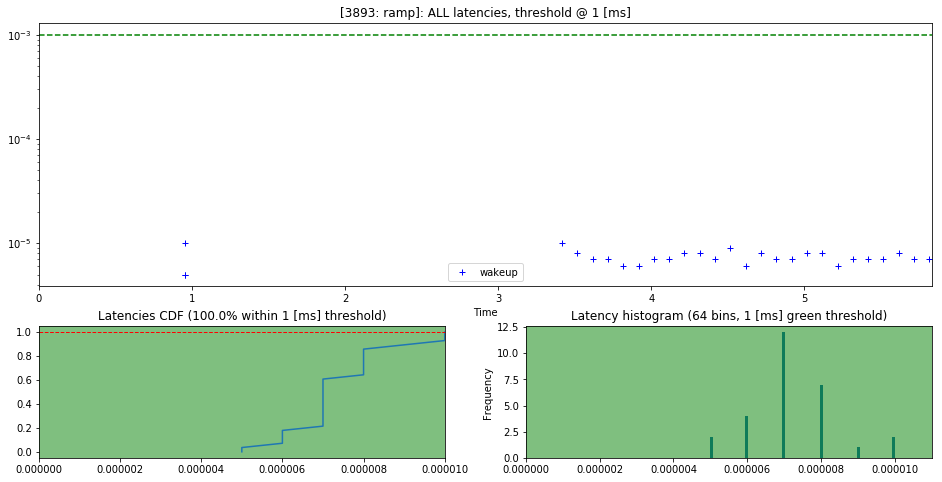

In [17]:
latency_stats_df_kpti = trace_kpti.analysis.latency.plotLatency('ramp')

In [15]:
# Plot statistics on task latencies
latency_stats_df.T

,count,mean,std,min,50%,95%,99%,max,100.0%
latency,44.0,0.000007,0.000002,0.000002,0.000007,0.00001,0.000012,0.000012,0.001


In [18]:
latency_stats_df_kpti.T

,count,mean,std,min,50%,95%,99%,max,100.0%
latency,28.0,0.000007,0.000001,0.000005,0.000007,0.00001,0.00001,0.00001,0.001
